
# **CamemBERT**
## Team Neuchâtel

## 1. Setup and Data Acquisition


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
# download the dataset from the competition page
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

  0% 0.00/303k [00:00<?, ?B/s]
100% 303k/303k [00:00<00:00, 81.2MB/s]


In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.3 MB/s eta 0:00:00


## 2. Environment Preparation


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import CamembertForSequenceClassification, CamembertTokenizer, AdamW
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Constants
MAX_LEN = 128  # Maximum length of the input sentences
BATCH_SIZE = 32  # Batch size for training and evaluation
EPOCHS = 15  # Number of epochs for training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use CUDA if available

## 3. Data Preprocessing


In [ ]:
def load_data(train_file, test_file):
    # Function to load training and test data from CSV files
    df_train = pd.read_csv(train_file, index_col='id')
    df_test = pd.read_csv(test_file, index_col='id')
    return df_train, df_test

In [ ]:
def encode_sentences(tokenizer, sentences, max_len):
    # Function to tokenize sentences
    return [tokenizer.encode(sent, add_special_tokens=True, max_length=max_len, truncation=True) for sent in sentences]

In [ ]:
def create_attention_masks(input_ids):
    # Function to create attention masks for input ids
    return [[float(i > 0) for i in seq] for seq in input_ids]

## 4. Model Preparation


In [ ]:
def prepare_data(df_train, tokenizer):
    # Function to prepare the data for training

    # Map difficulty levels to numerical values for processing
    difficulty_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
    df_train['difficulty'] = df_train['difficulty'].replace(difficulty_mapping)

    # Extract sentences from the training data
    text = df_train['sentence'].tolist()

    # Tokenize the sentences
    input_ids = encode_sentences(tokenizer, text, MAX_LEN)

    # Pad the tokenized sentences to a uniform length
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # Create attention masks for the tokenized input
    attention_masks = create_attention_masks(input_ids)

    # Split data into training and validation sets
    return train_test_split(input_ids, df_train['difficulty'].tolist(), attention_masks, random_state=42, test_size=0.1)

In [ ]:
def initialize_model(difficulty_mapping):
    # Function to initialize the Camembert model for sequence classification

    model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=len(difficulty_mapping))
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
    return model, optimizer

In [ ]:
def calculate_accuracy(preds, labels):
    # Function to calculate accuracy of predictions
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## 5. Model Training


In [ ]:
def train_model(model, train_dataloader, optimizer):
    # Move model to the correct device (GPU or CPU)
    model.to(DEVICE)

    # Initialize a list to keep track of training loss
    train_loss_set = []

    # Iterate over all training epochs
    for _ in tqdm(range(EPOCHS), desc="Epoch"):
        model.train()  # Set model to training mode
        total_train_loss = 0  # Initialize total loss for the epoch

        # Iterate over each batch in the training data
        for batch in train_dataloader:
            batch = tuple(t.to(DEVICE) for t in batch)  # Move batch to the correct device
            b_input_ids, b_input_mask, b_labels = batch

            optimizer.zero_grad()  # Reset gradients before forward pass
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss  # Compute loss
            total_train_loss += loss.item()  # Aggregate loss

            loss.backward()  # Backpropagate errors
            optimizer.step()  # Update model parameters

        # Record average loss for this epoch
        train_loss_set.append(total_train_loss / len(train_dataloader))

    return train_loss_set

## 6. Evaluation and Prediction

In [ ]:
def evaluate_model(model, validation_dataloader):
    # Function to evaluate the model

    # Set model to evaluation mode and initialize lists for predictions and labels
    model.eval()
    predictions , true_labels = [], []

    # Process validation data in batches
    for batch in validation_dataloader:
        batch = tuple(t.to(DEVICE) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Predict without computing gradients for efficiency
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        # Detach predictions from the graph and prepare for evaluation
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Flatten predictions and true labels for evaluation metrics
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(flat_true_labels, flat_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='weighted')
    return accuracy, precision, recall, f1, flat_predictions, flat_true_labels

In [ ]:
def predict(model, tokenizer, df_test):
    # Function to predict the difficulty of sentences in the test dataset

    # Extract and tokenize test data sentences
    text_test = df_test['sentence'].tolist()
    tokenized_comments_ids = encode_sentences(tokenizer, text_test, MAX_LEN)
    tokenized_comments_ids = pad_sequences(tokenized_comments_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    attention_masks = create_attention_masks(tokenized_comments_ids)

    # Convert tokenized sentences and attention masks to tensors
    prediction_inputs = torch.tensor(tokenized_comments_ids)
    prediction_masks = torch.tensor(attention_masks)

    # Perform batch prediction with the model
    model.eval()
    flat_predictions = []
    for i in range(0, len(prediction_inputs), BATCH_SIZE):
        batch_inputs = prediction_inputs[i:i+BATCH_SIZE].to(DEVICE)
        batch_masks = prediction_masks[i:i+BATCH_SIZE].to(DEVICE)
        with torch.no_grad():
            outputs = model(batch_inputs, attention_mask=batch_masks)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        flat_predictions.extend(np.argmax(logits, axis=1).flatten())

    # Map numerical predictions to difficulty levels and save to CSV
    replacement_dict = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
    predicted_difficulties = [replacement_dict[pred] for pred in flat_predictions]
    submission_df = pd.DataFrame(data={'difficulty': predicted_difficulties})
    submission_df.index.names = ['id']
    submission_df.reset_index(inplace=True)
    submission_file = 'submission.csv'
    submission_df.to_csv(submission_file, index=False)
    return submission_file

## 7. Code Execution and Display of Performance Metrics


sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 15/15 [21:33<00:00, 86.23s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

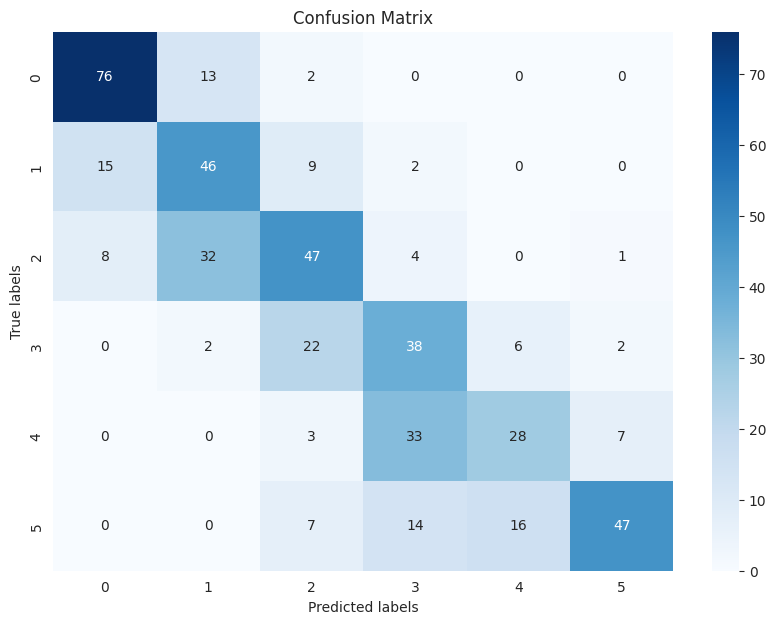

Training losses: [1.5316573187156959, 1.1457649593000059, 0.9665384575172707, 0.8372902874593382, 0.699751584176664, 0.5600287989333824, 0.4336185559078499, 0.3431767799236156, 0.25608227953866675, 0.21299929188357458, 0.15566042543009476, 0.12575228790994045, 0.10304020375565247, 0.09180114993618595, 0.08363044246065396]
Validation Accuracy: 0.5875
Precision: 0.6079
Recall: 0.5875
F1 Score: 0.5883


In [ ]:
# Load data and prepare training and validation sets
df_train, df_test = load_data("training_data.csv", "unlabelled_test_data.csv")
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=True)
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = prepare_data(df_train, tokenizer)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Set up data loaders for training and validation
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

# Initialize model and optimizer, and train the model
model, optimizer = initialize_model({'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5})
train_loss_set = train_model(model, train_dataloader, optimizer)

# Evaluate the model and predict using test data
accuracy, precision, recall, f1, predicted_labels, true_labels = evaluate_model(model, validation_dataloader)
submission_file = predict(model, tokenizer, df_test)

# Download the submission file (for the Kaggle competition) and the trained model (for our Streamlit app)
from google.colab import files
files.download(submission_file)

# Plot confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()

# Print out performance metrics
print(f"Training losses: {train_loss_set}")
print('Validation Accuracy: {:0.4f}'.format(accuracy))
print('Precision: {:0.4f}'.format(precision))
print('Recall: {:0.4f}'.format(recall))
print('F1 Score: {:0.4f}'.format(f1))